In [7]:
import math
import numpy as np
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
from multiprocessing import Pool
from time import time
import tsfel

In [ ]:
def magnitude(sample):
    mag_vector = []
    for s in sample:
        mag_vector.append(math.sqrt(sum([s[0]**2, s[1]**2, s[2]**2])))
    return mag_vector

def A(sample):
    feat = []
    for col in range(0,sample.shape[0]):
        average = np.average(sample[col,:])
        feat.append(average)

    return np.mean(feat)


def SD(sample):
    feat = []
    for col in range(0, sample.shape[0]):
        std = np.std(sample[col,:])
        feat.append(std)

    return np.mean(feat)


def AAD(sample):
    feat = []
    for col in range(0, sample.shape[0]):
        data = sample[col,:]
        add = np.mean(np.absolute(data - np.mean(data)))
        feat.append(add)

    return np.mean(feat)


def ARA(sample):
    #Average Resultant Acceleration[1]:
    # Average of the square roots of the sum of the values of each axis squared √(xi^2 + yi^2+ zi^2) over the ED
    feat = []
    sum_square = 0
    sample = np.power(sample, 2)
    for col in range(0, sample.shape[0]):
        sum_square = sum_square + sample[col,:]

    sample = np.sqrt(sum_square)
    average = np.average(sample)
    feat.append(average)
    return np.mean(feat)

def COR(sample):
    feat = []
    for axis_i in range(0, sample.shape[0]):
        for axis_j in range(axis_i+1, sample.shape[0]):
            cor = np.corrcoef(sample[axis_i, :], sample[axis_j, :])
            cor = 0 if np.isnan(cor) else cor[0][1]
            feat.append(cor)

    return np.mean(feat)

def TBP(sample):
    from scipy import signal
    feat = []
    sum_of_time = 0
    for col in range(0, sample.shape[0]):
        data = sample[col, :]
        peaks = signal.find_peaks_cwt(data, np.arange(1,4))

        feat.append(peaks)

    return feat

def mag_mean(sample):
    mag = magnitude(sample)
    ft_mean = np.mean(mag)
    return ft_mean

def mag_std(sample):
    mag = magnitude(sample)
    ft_std = np.std(mag)
    return ft_std


def feature_extraction(X):
    """
    Derive three activity intensity cues: mean and standard deviation of activity intensity,
    and duration of immobility during assessment window to summarize the data.
    # Average - A,
    # Standard Deviation - SD,
    # Average Absolute Difference - AAD,
    # Average Resultant Acceleration - ARA(1),
    """
    features = []
    for sample in tqdm(X):
        #mag = magnitude(sample)
        #ft_mean = np.mean(mag)
        #ft_std = np.std(mag)
        features = A(sample)
        #features = np.hstack((features, SD(sample)))
        #features = np.hstack((features, AAD(sample)))
        #features = np.hstack((features, ARA(sample)))
        # calculate duration of immobility
        #features.append([ft_mean, ft_std])

    return features

In [4]:
import math, os
import numpy as np
from scipy import signal
import pandas as pd
import resampy

##predefined filter coefficients, as found by Jan Brond
A_coeff = np.array(
    [1, -4.1637, 7.5712,-7.9805, 5.385, -2.4636, 0.89238, 0.06361, -1.3481, 2.4734, -2.9257, 2.9298, -2.7816, 2.4777,
     -1.6847, 0.46483, 0.46565, -0.67312, 0.4162, -0.13832, 0.019852])
B_coeff = np.array(
    [0.049109, -0.12284, 0.14356, -0.11269, 0.053804, -0.02023, 0.0063778, 0.018513, -0.038154, 0.048727, -0.052577,
     0.047847, -0.046015, 0.036283, -0.012977, -0.0046262, 0.012835, -0.0093762, 0.0034485, -0.00080972, -0.00019623])

def pptrunc(data, max_value):
    '''
    Saturate a vector such that no element's absolute value exceeds max_abs_value.
    Current name: absolute_saturate().
      :param data: a vector of any dimension containing numerical data
      :param max_value: a float value of the absolute value to not exceed
      :return: the saturated vector
    '''
    outd = np.where(data > max_value, max_value, data)
    return np.where(outd < -max_value, -max_value, outd)

def trunc(data, min_value):
  
    '''
    Truncate a vector such that any value lower than min_value is set to 0.
    Current name zero_truncate().
    :param data: a vector of any dimension containing numerical data
    :param min_value: a float value the elements of data should not fall below
    :return: the truncated vector
    '''

    return np.where(data < min_value, 0, data)

def runsum(data, length, threshold):
    '''
    Compute the running sum of values in a vector exceeding some threshold within a range of indices.
    Divides the data into len(data)/length chunks and sums the values in excess of the threshold for each chunk.
    Current name run_sum().
    :param data: a 1D numerical vector to calculate the sum of
    :param len: the length of each chunk to compute a sum along, as a positive integer
    :param threshold: a numerical value used to find values exceeding some threshold
    :return: a vector of length len(data)/length containing the excess value sum for each chunk of data
    '''
    
    N = len(data)
    cnt = int(math.ceil(N/length))

    rs = np.zeros(cnt)

    for n in range(cnt):
        for p in range(length*n, length*(n+1)):
            if p<N and data[p]>=threshold:
                rs[n] = rs[n] + data[p] - threshold

    return rs

def counts(data, filesf, B=B_coeff, A=A_coeff):
    '''
    Get activity counts for a set of accelerometer observations.
    First resamples the data frequency to 30Hz, then applies a Butterworth filter to the signal, then filters by the
    coefficient matrices, saturates and truncates the result, and applies a running sum to get the final counts.
    Current name get_actigraph_counts()
    :param data: the vertical axis of accelerometer readings, as a vector
    :param filesf: the number of observations per second in the file
    :param a: coefficient matrix for filtering the signal, as found by Jan Brond
    :param b: coefficient matrix for filtering the signal, as found by Jan Brond
    :return: a vector containing the final counts
    '''
    
    deadband = 0.068
    sf = 30
    peakThreshold = 2.13
    adcResolution = 0.0164
    integN = 10
    gain = 0.965

    #if filesf>sf:
    data = resampy.resample(np.asarray(data), filesf, sf)

    B2, A2 = signal.butter(4, np.array([0.01, 7])/(sf/2), btype='bandpass')
    dataf = signal.filtfilt(B2, A2, data)

    B = B * gain

    #NB: no need for a loop here as we only have one axis in array
    fx8up = signal.lfilter(B, A, dataf)

    fx8 = pptrunc(fx8up[::3], peakThreshold) #downsampling is replaced by slicing with step parameter

    return runsum(np.floor(trunc(np.abs(fx8), deadband)/adcResolution), integN, 0)

In [5]:
def POI(sample):
    """
    Calculate the percentage of time spent immobile in a window
    """
    def calc_mob_per_min(countx, county, countz):
        mob_per_min = []
        for i in range(0, len(countx), 60):
            countx_1m = np.mean(countx[i:i+60])
            county_1m = np.mean(county[i:i+60])
            countz_1m = np.mean(countz[i:i+60])
            mob_per_min.append(np.mean([countx_1m, county_1m, countz_1m]))
        return mob_per_min

    def percentagem_of_immobility(mob_per_min):
        mob_per_min = np.asarray(mob_per_min)
        inactivity_counts = (mob_per_min <= 4).sum() 
        return inactivity_counts/len(mob_per_min)

    # calculate counts per axis
    c1_1s = counts(sample[0], 10)
    c2_1s = counts(sample[1], 10)
    c3_1s = counts(sample[2], 10)
    mob_per_min = calc_mob_per_min(c1_1s, c2_1s, c3_1s)
    POI = percentagem_of_immobility(mob_per_min)
    return POI
    
        

In [29]:
def cal_corr_mean(clin_variable, y, feat):
    
    col_idx = y_col_names.index(clin_variable)
    y_target = np.array(y[:, col_idx].astype(float))
    corr, pvalue = spearmanr(feat, y_target)
    return corr, pvalue

In [22]:
data_input_file = "/home/jsenadesouza/DA-healthy2patient/results/outcomes/dataset/f10_t1800_outcomesscore_patientid_acc_30minmargin_measurednowcol_30min_10hz_filtered.npz"

tmp = np.load(data_input_file, allow_pickle=True)
X = tmp['X']
y = tmp['y']
y_col_names = list(tmp['y_col_names'])
X = np.transpose(np.squeeze(X), (0, 1, 2))
print(X.shape)

(6499, 18000, 3)


In [22]:
print("Extracting Features")
start = time()
with Pool(10) as p:
        X_feat = p.map(ARA, X)
end = time()
print(f"{end-start:.2} seconds passed.")
#X_feat = np.array(feature_extraction(X))

Extracting Features
7.4 seconds passed.


In [31]:
import librosa

X_feat = []
for sample in X:

    sample_mag = np.array(magnitude(sample))

    mfccs = librosa.feature.mfcc(y=sample_mag, sr=10)
    X_feat.append(np.mean(mfccs))
    

In [24]:
sample_mag.shape

(18000,)

(20, 36)


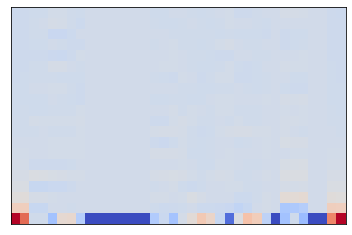

In [25]:
import librosa.display
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=10)

In [32]:
print(f"spearmanr correlation")
variables = np.array(y_col_names)[[0, 2, 4, 5, 6, 8, 10, 12, 14, 16]]
for clin_variable in variables:
    corr, pvalue = cal_corr_mean(clin_variable, y, X_feat)
    print(f"{corr:.2f} ({pvalue:.6f})")
    

spearmanr correlation
-0.09 (0.000000)
0.09 (0.000000)
0.00 (0.844048)
0.03 (0.037337)
0.10 (0.000000)
-0.02 (0.053942)
-0.00 (0.900299)
0.15 (0.000000)
-0.10 (0.000000)
-0.04 (0.004657)


In [4]:
variables_class = np.array(y_col_names)[[1, 3, 5, 7, 9, 11, 13, 15, 16]]
for clin_variable in variables_class:
    
    col_idx = y_col_names.index(clin_variable)
    y_target = np.array(y[:, col_idx])
    print(clin_variable)
    names, counts = np.unique(y_target, return_counts=True)
    total = np.sum(counts)
    for i in range(len(names)):
        print(f"{names[i]}: {counts[i]/total*100:.2f}")

heart_rate_class
high: 30.73
low: 3.55
normal: 65.72
temp_class
high: 22.39
low: 6.37
normal: 71.24
is_dead
0: 81.37
1: 18.63
pain_score_class
mild: 92.66
severe: 7.34
sofa_score_class
low: 82.98
moderate: 17.02
map_class
high: 8.19
low: 43.61
normal: 48.21
braden_score_class
high: 37.70
mild: 62.30
spo2_class
low: 15.54
normal: 84.46
cam
-1: 0.94
0: 80.37
1: 18.70
